Import Data

**Start**

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import PIL
import PIL.Image
import os, torch, shutil, numpy as np
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
import os
import fvcore
import torchmetrics

In [2]:

labels=['fractured','not fractured']

img_path= "/home/mihir_dixit/NNproject/data/train/"
img_list=[]
label_list=[]
for label in labels:
    for img_file in os.listdir(img_path+label):
        img_list.append(img_path+label+'/'+img_file)
        label_list.append(label)
train_df= pd.DataFrame({'img':img_list,'label':label_list})
train_df = train_df[train_df['img'].str.contains(r'/\d{2,3}\.jpg$')]

print(train_df['img'].head())
print(train_df['img'].apply(lambda x: os.path.basename(x)))

4      /home/mihir_dixit/NNproject/data/train/fractur...
36     /home/mihir_dixit/NNproject/data/train/fractur...
40     /home/mihir_dixit/NNproject/data/train/fractur...
57     /home/mihir_dixit/NNproject/data/train/fractur...
104    /home/mihir_dixit/NNproject/data/train/fractur...
Name: img, dtype: object
4       100.jpg
36       10.jpg
40      101.jpg
57      102.jpg
104     103.jpg
         ...   
8646     66.jpg
8649     67.jpg
8653     68.jpg
8696     69.jpg
8786     70.jpg
Name: img, Length: 172, dtype: object


Import Dependencies



**Dataset Preparation and DataLoader Setup**




In [3]:

class CustomImageDataset(Dataset):
    """
    A dataset class for organizing and loading images with their respective class labels.
    """

    def __init__(self, root_dir, data_type, transforms=None):

        self.transforms = transforms
        self.image_paths = sorted(glob(os.path.join(root_dir, data_type, "*", "*")))
        self.class_to_idx = {}
        self.class_counts = {}

        class_index = 0
        for path in self.image_paths:
            class_name = self._extract_class_name(path)
            if class_name not in self.class_to_idx:
                self.class_to_idx[class_name] = class_index
                self.class_counts[class_name] = 1
                class_index += 1
            else:
                self.class_counts[class_name] += 1

    def _extract_class_name(self, path):

        return os.path.basename(os.path.dirname(path))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):

        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")
        label = self.class_to_idx[self._extract_class_name(image_path)]

        if self.transforms:
            image = self.transforms(image)

        return image, label


def create_dataloaders(root_dir, transform, batch_size, split_ratios=(0.8,), num_workers=4):

    train_val_dataset = CustomImageDataset(root_dir=root_dir, data_type="train", transforms=transform)
    test_dataset = CustomImageDataset(root_dir=root_dir, data_type="val", transforms=transform)

    train_size = int(len(train_val_dataset) * split_ratios[0])
    val_size = len(train_val_dataset) - train_size
    train_dataset, val_dataset = random_split(train_val_dataset, lengths=[train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader, train_val_dataset.class_to_idx


In [4]:
import torchvision.transforms as T

root = "/home/mihir_dixit/NNproject/data/"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)])

# Create DataLoaders
tr_dl, val_dl, ts_dl, classes = create_dataloaders(root_dir=root, transform=tfs, batch_size=32)

print(f"Number of training images: {len(tr_dl.dataset)}")
print(f"Number of validation images: {len(val_dl.dataset)}")
print(f"Number of test images: {len(ts_dl.dataset)}")
print(f"Classes: {classes}")

Number of training images: 7090
Number of validation images: 1773
Number of test images: 600
Classes: {'fractured': 0, 'not fractured': 1}


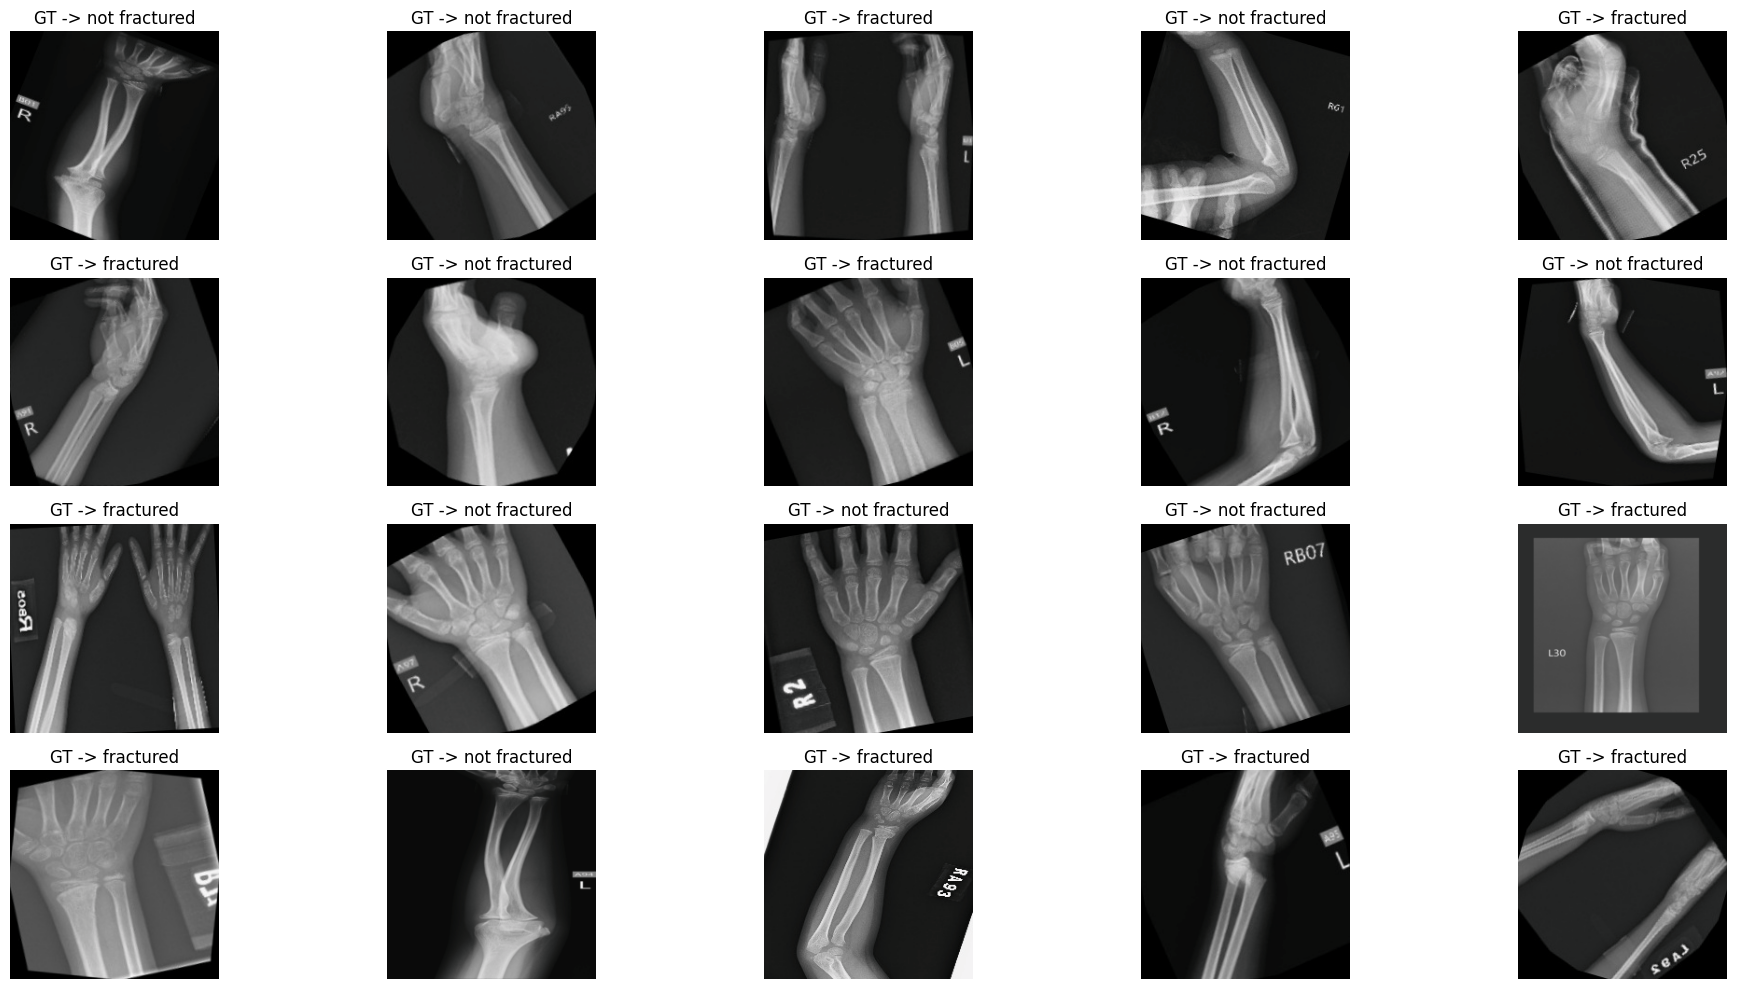

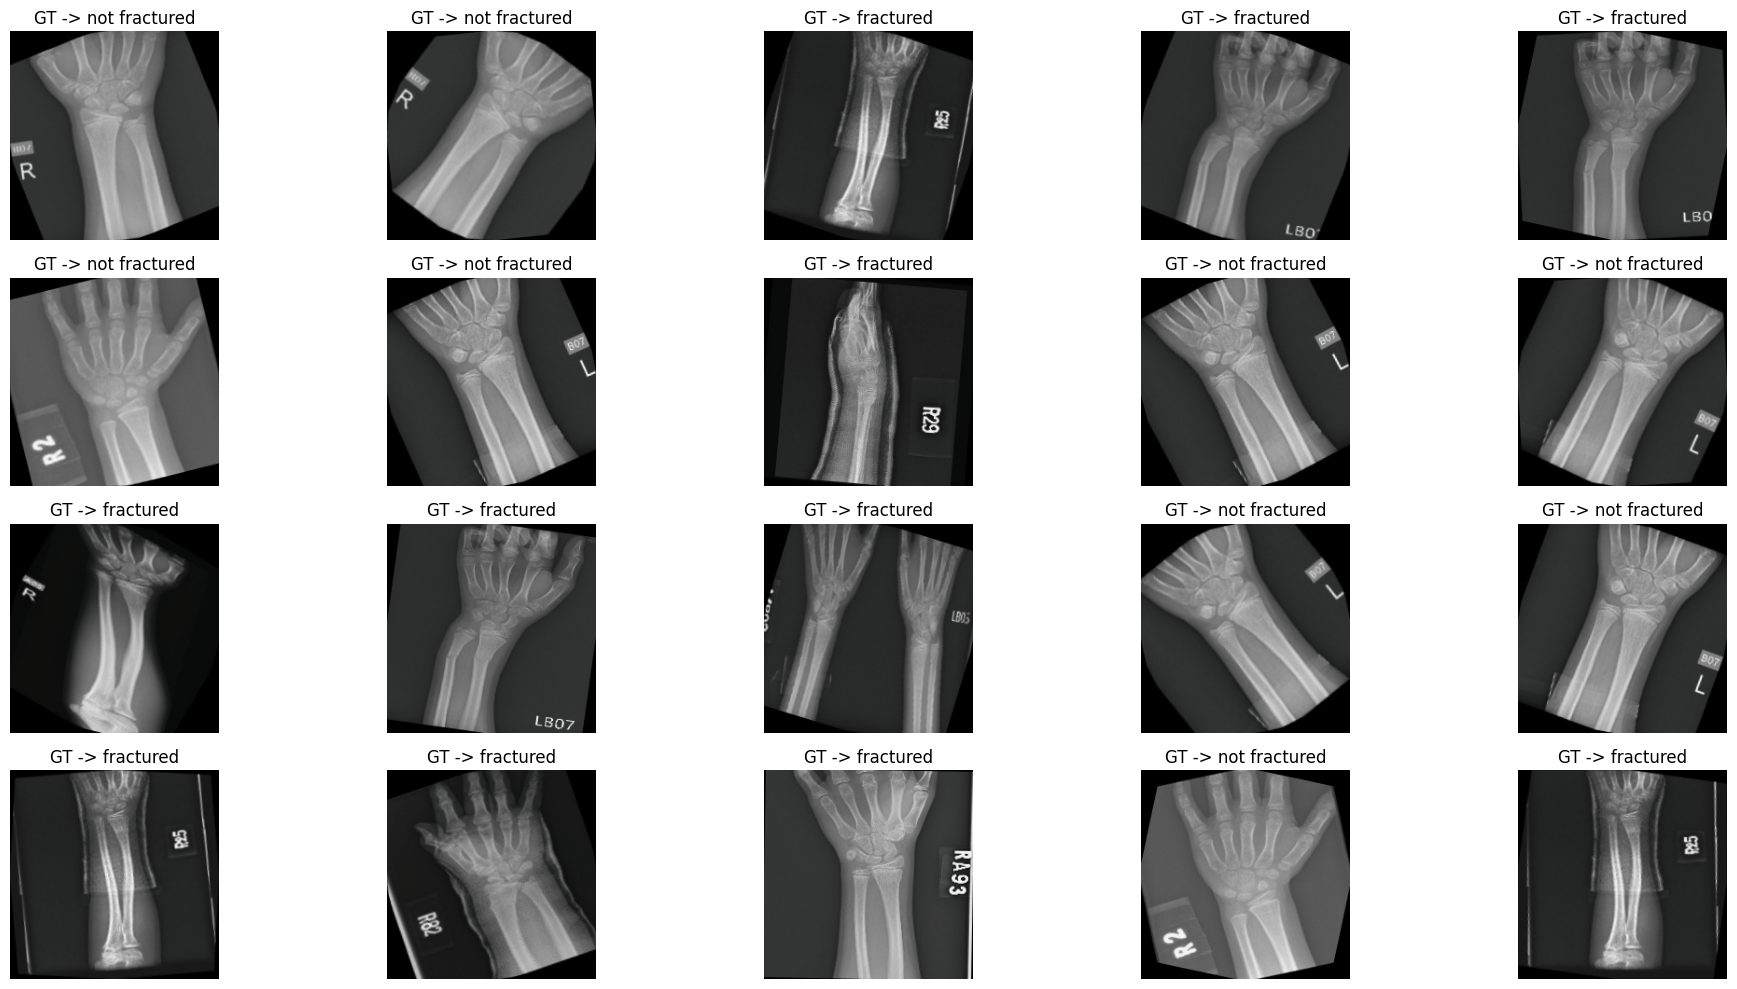

In [5]:
import random
from matplotlib import pyplot as plt
import numpy as np
import torchvision.transforms as T

def tensor_to_image(tensor, image_type="rgb"):
    """
    Converts a tensor into an image with inverse normalization.

    Args:
        tensor (Tensor): Input tensor.
        image_type (str): Type of image ('rgb' or 'gray').

    Returns:
        np.ndarray: Converted image as a NumPy array.
    """
    gray_transform = T.Compose([
        T.Normalize(mean=[0.0], std=[1 / 0.5]),
        T.Normalize(mean=[-0.5], std=[1.0])
    ])
    rgb_transform = T.Compose([
        T.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0])
    ])
    inv_transform = gray_transform if image_type == "gray" else rgb_transform

    image = inv_transform(tensor).detach().cpu()     # Apply inverse transformation
    image = image.squeeze().permute(1, 2, 0).numpy() * 255
    return image.astype(np.uint8)


def visualize_dataset(dataset, num_images, rows, color_mode=None, class_names=None):
    assert color_mode in [None, "rgb", "gray"], "Color mode must be 'rgb', 'gray', or None!"
    if color_mode == "rgb":
        cmap = None  # Use default RGB visualization
    else:
        cmap = "gray"

    # Set up the figure
    plt.figure(figsize=(20, 10))
    indices = random.sample(range(len(dataset)), num_images)  # Randomly select indices

    for idx, dataset_index in enumerate(indices):
        image, label = dataset[dataset_index]

        # Plot the image
        plt.subplot(rows, num_images // rows, idx + 1)
        plt.imshow(tensor_to_image(image, image_type=color_mode), cmap=cmap)
        plt.axis('off')

        # Add title with class name or label
        title = f"GT -> {class_names[int(label)]}" if class_names else f"GT -> {label}"
        plt.title(title)

    plt.tight_layout()
    plt.show()

visualize_dataset(
    dataset=tr_dl.dataset,
    num_images=20,
    rows=4,
    color_mode="rgb",
    class_names=list(classes.keys())
)
visualize_dataset(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))


Training and Validation of unpruned CNNs

Helper Functions

In [6]:
!pip install tqdm
import torchmetrics
from tqdm import tqdm
from sklearn.metrics import f1_score
from fvcore.nn import FlopCountAnalysis
import torch
import torchvision.models as models
import torch.nn as nn
import copy
from torch.nn.utils import prune
import torch.nn.utils.prune as prune

def train_setup(model):
    return model.to("cuda").eval(), 10, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params=model.parameters(), lr=3e-4)

def to_device(batch, device):
    return batch[0].to(device), batch[1].to(device)

def get_metrics_train(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1):
    outputs = model(ims)
    loss = loss_fn(outputs, gts)
    epoch_loss += loss.item()

    _, preds = torch.max(outputs, 1)
    epoch_acc += torch.sum(preds == gts).item()

    f1 = f1_score(gts.cpu().numpy(), preds.cpu().numpy(), average='macro')
    epoch_f1 += f1

    return loss, epoch_loss, epoch_acc, epoch_f1

def get_metrics_val(model, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1):
    """
    Computes loss, accuracy, and F1-score for a validation batch.
    Does not track gradients.
    """
    with torch.no_grad():
        outputs = model(ims)
        loss = loss_fn(outputs, gts)
        val_epoch_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        val_epoch_acc += torch.sum(preds == gts).item()

        f1 = f1_score(gts.cpu().numpy(), preds.cpu().numpy(), average='macro')
        val_epoch_f1 += f1

    return loss, val_epoch_loss, val_epoch_acc, val_epoch_f1

save_prefix, save_dir = "fracture", "saved_models"

def train_one_epoch(model, tr_dl, loss_fn, optimizer, device):
    model.train()
    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl), total=len(tr_dl), desc="Training"):
        ims, gts = to_device(batch, device)
        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics_train(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return epoch_loss / len(tr_dl), epoch_acc / len(tr_dl.dataset), epoch_f1 / len(tr_dl)

def validate_one_epoch(model, val_dl, loss_fn, device):
    model.eval()
    val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(val_dl), total=len(val_dl), desc="Validation"):
        ims, gts = to_device(batch, device)
        loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics_val(model, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)
    return val_epoch_loss / len(val_dl), val_epoch_acc / len(val_dl.dataset), val_epoch_f1 / len(val_dl)

def calculate_macs(model, input_size=(1, 3, 224, 224)):
    model.eval()
    dummy_input = torch.randn(*input_size).to(next(model.parameters()).device)
    flops = FlopCountAnalysis(model, dummy_input)
    return flops.total()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())
def calculate_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    total_size = (param_size + buffer_size) / 1e6  # MB
    return total_size
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def get_model_size(model, filename="temp_model.pth"):
    torch.save(model.state_dict(), filename)
    size = os.path.getsize(filename) / 1e6  # Size in MB
    os.remove(filename)
    return size
def calculate_sparsity(model):

    total_weights = 0
    zero_weights = 0
    for param in model.parameters():
        total_weights += param.numel()
        zero_weights += torch.sum(param == 0).item()
    sparsity = (zero_weights / total_weights) * 100
    return sparsity


def apply_unstructured_pruning(model, amount=0.2):
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )

    # Remove pruning reparameterization to make pruning permanent
    for module, _ in parameters_to_prune:
        prune.remove(module, 'weight')

    return model


import torch
from torch.nn.utils import prune

def apply_structured_pruning(model, amount=0.2):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name="weight", amount=amount, n=1, dim=0)
            print(f"Applied {amount * 100:.0f}% L1 Structured Pruning on {name}")
    return model

def make_pruning_permanent(model): # Make pruning permanent
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) and hasattr(module, "weight_mask"):
            prune.remove(module, "weight")
            print(f"Pruning made permanent for {name}")
    return model
def calculate_macs_fvcore(model, input_size=(1, 3, 224, 224)):
    model.eval()
    dummy_input = torch.randn(*input_size).to(next(model.parameters()).device)
    flops = FlopCountAnalysis(model, dummy_input)
    macs = flops.total() / 2
    return macs
def calculate_block_pruning_sparsity(original_model, pruned_model):
    original_params = sum(p.numel() for p in original_model.parameters())
    pruned_params = sum(p.numel() for p in pruned_model.parameters())
    sparsity = (original_params - pruned_params) / original_params
    return sparsity
import torch.nn.utils.prune as prune


def rebuild_pruned_model(model):
    new_model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) and hasattr(module, "weight_mask"):
            weight = module.weight.detach() * module.weight_mask.detach()            # Identify unpruned filters
            non_zero_filters = (weight.abs().sum(dim=(1, 2, 3)) > 0).nonzero(as_tuple=False).squeeze()
            new_out_channels = non_zero_filters.size(0)
            new_in_channels = module.in_channels
            new_layer = nn.Conv2d(
                in_channels=new_in_channels,
                out_channels=new_out_channels,
                kernel_size=module.kernel_size,
                stride=module.stride,
                padding=module.padding,
                dilation=module.dilation,
                groups=module.groups,
                bias=(module.bias is not None),
            )

            new_layer.weight.data = module.weight[non_zero_filters].clone()
            if module.bias is not None:
                new_layer.bias.data = module.bias[non_zero_filters].clone()

            parent_name, attr_name = name.rsplit('.', 1) if '.' in name else ("", name)
            parent_module = new_model if not parent_name else dict(new_model.named_modules())[parent_name]
            setattr(parent_module, attr_name, new_layer)

    return new_model

def prune_blocks(model, blocks_to_prune):
    # Manually remove specified blocks
    for block_name in blocks_to_prune:
        parent_name, attr_name = block_name.rsplit('.', 1)
        parent_module = dict(model.named_modules())[parent_name]
        setattr(parent_module, attr_name, nn.Identity())  # Replace with Identity
    return model

def append_history(all_histories, history, model_name, pruning_method, epochs):
    for epoch in range(epochs):
        record = {
            'Model': model_name,
            'Pruning Method': pruning_method,
            'Epoch': epoch + 1,
            'Train Loss': history['train_loss'][epoch],
            'Validation Loss': history['val_loss'][epoch],
            'Train Accuracy': history['train_acc'][epoch],
            'Validation Accuracy': history['val_acc'][epoch],
            'Train F1-Score': history['train_f1'][epoch],
            'Validation F1-Score': history['val_f1'][epoch]
        }
        all_histories.append(record)

def save_all_histories_to_csv(all_histories, filename="combined_training_history.csv", save_dir="metrics"):
    os.makedirs(save_dir, exist_ok=True)
    df_all_histories = pd.DataFrame(all_histories)
    csv_path = os.path.join(save_dir, filename)
    df_all_histories.to_csv(csv_path, index=False)
    print(f"Saved all training histories to {csv_path}")

models_dict = {
    "resnet50": models.resnet50(pretrained=True),
    # "efficientnet_b0": models.efficientnet_b0(pretrained=True),
    # "vit_b_16": models.vit_b_16(pretrained=True),
}

for model_name, model in models_dict.items():
    # Modify the final layer to match the number of classes
    if model_name.startswith("resnet"):
        model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
    elif model_name.startswith("efficientnet"):
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(classes))
    elif model_name.startswith("vit"):
        model.heads.head = torch.nn.Linear(model.heads.head.in_features, len(classes))
save_prefix, save_dir = "fracture", "saved_models"
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

all_histories = []


/home/mihir_dixit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mihir_dixit/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


**Unpruned Model**

In [7]:
# === 1. Training the Unpruned Model ===
print(f"\n--- Training Unpruned Model: {model_name} ---")
epochs = 10
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
unpruned_macs = calculate_macs(model)
unpruned_total_params = count_parameters(model)
unpruned_model_size = calculate_model_size(model)
unpruned_file_model_size = get_model_size(model)
unpruned_sparsity = calculate_sparsity(model)
print(f"Post-Unstructured Pruning Metrics for {model_name}:")
print(f"MACs: {unpruned_macs / 1e9:.2f} GFLOPs")
print(f"Total Parameters: {unpruned_total_params / 1e6:.2f} Million")
print(f"Model Size (Calculated): {unpruned_model_size:.2f} MB")
print(f"Model Size (File): {unpruned_file_model_size:.2f} MB")
print(f"Model Sparsity after Unstructured Pruning: {unpruned_sparsity:.2f}%")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5

history_unpruned = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}

original_model = model.to(device)

for epoch in range(epochs):
    tr_loss, tr_acc, tr_f1 = train_one_epoch(original_model, tr_dl, loss_fn, optimizer, device)
    history_unpruned['train_loss'].append(tr_loss)
    history_unpruned['train_acc'].append(tr_acc)
    history_unpruned['train_f1'].append(tr_f1)

    print(f"\nEpoch {epoch + 1}/{epochs} - Training Completed!")
    print(f"Train Loss: {tr_loss:.4f} | Train Accuracy: {tr_acc:.4f} | Train F1-Score: {tr_f1:.4f}")

    val_loss, val_acc, val_f1 = validate_one_epoch(original_model, val_dl, loss_fn, device)
    history_unpruned['val_loss'].append(val_loss)
    history_unpruned['val_acc'].append(val_acc)
    history_unpruned['val_f1'].append(val_f1)

    print(f"Epoch {epoch + 1}/{epochs} - Validation Completed!")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f} | Validation F1-Score: {val_f1:.4f}")

    if val_loss < (best_loss + threshold):
        os.makedirs(save_dir, exist_ok=True)
        best_loss = val_loss
        torch.save(original_model.state_dict(), f"{save_dir}/{save_prefix}_{model_name}_unpruned_best_model.pth")
        not_improved = 0
        print(f"Saved Best Unpruned Model at Epoch {epoch + 1}")
    else:
        not_improved += 1
        print(f"No improvement in validation loss for {not_improved} consecutive epochs.")
        if not_improved >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

all_histories = []
append_history(all_histories, history_unpruned, model_name, 'Unpruned', len(history_unpruned['train_loss']))
save_all_histories_to_csv(all_histories, filename="combined_training_history.csv", save_dir="metrics")




--- Training Unpruned Model: resnet50 ---


Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 16 time(s)


Post-Unstructured Pruning Metrics for resnet50:
MACs: 4.11 GFLOPs
Total Parameters: 23.51 Million
Model Size (Calculated): 94.26 MB
Model Size (File): 94.36 MB
Model Sparsity after Unstructured Pruning: 0.00%


Training: 100%|██████████| 222/222 [01:02<00:00,  3.56it/s]


Epoch 1/10 - Training Completed!
Train Loss: 0.1841 | Train Accuracy: 0.9212 | Train F1-Score: 0.9178



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.87it/s]


Epoch 1/10 - Validation Completed!
Validation Loss: 0.0603 | Validation Accuracy: 0.9791 | Validation F1-Score: 0.9790
Saved Best Unpruned Model at Epoch 1


Training: 100%|██████████| 222/222 [01:02<00:00,  3.56it/s]


Epoch 2/10 - Training Completed!
Train Loss: 0.0552 | Train Accuracy: 0.9807 | Train F1-Score: 0.9799



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.78it/s]

Epoch 2/10 - Validation Completed!
Validation Loss: 0.4079 | Validation Accuracy: 0.8838 | Validation F1-Score: 0.8769
No improvement in validation loss for 1 consecutive epochs.



Training: 100%|██████████| 222/222 [01:02<00:00,  3.55it/s]


Epoch 3/10 - Training Completed!
Train Loss: 0.0398 | Train Accuracy: 0.9877 | Train F1-Score: 0.9871



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.86it/s]

Epoch 3/10 - Validation Completed!
Validation Loss: 0.1230 | Validation Accuracy: 0.9532 | Validation F1-Score: 0.9519
No improvement in validation loss for 2 consecutive epochs.



Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Epoch 4/10 - Training Completed!
Train Loss: 0.0275 | Train Accuracy: 0.9903 | Train F1-Score: 0.9899



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.81it/s]


Epoch 4/10 - Validation Completed!
Validation Loss: 0.0036 | Validation Accuracy: 0.9983 | Validation F1-Score: 0.9983
Saved Best Unpruned Model at Epoch 4


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Epoch 5/10 - Training Completed!
Train Loss: 0.0069 | Train Accuracy: 0.9980 | Train F1-Score: 0.9979



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.81it/s]

Epoch 5/10 - Validation Completed!
Validation Loss: 0.1101 | Validation Accuracy: 0.9639 | Validation F1-Score: 0.9623
No improvement in validation loss for 1 consecutive epochs.



Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Epoch 6/10 - Training Completed!
Train Loss: 0.0385 | Train Accuracy: 0.9873 | Train F1-Score: 0.9868



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.78it/s]

Epoch 6/10 - Validation Completed!
Validation Loss: 0.1800 | Validation Accuracy: 0.9419 | Validation F1-Score: 0.9401
No improvement in validation loss for 2 consecutive epochs.



Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Epoch 7/10 - Training Completed!
Train Loss: 0.0258 | Train Accuracy: 0.9918 | Train F1-Score: 0.9913



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.75it/s]


Epoch 7/10 - Validation Completed!
Validation Loss: 0.0106 | Validation Accuracy: 0.9961 | Validation F1-Score: 0.9960
Saved Best Unpruned Model at Epoch 7


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Epoch 8/10 - Training Completed!
Train Loss: 0.0054 | Train Accuracy: 0.9989 | Train F1-Score: 0.9988



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.83it/s]


Epoch 8/10 - Validation Completed!
Validation Loss: 0.0024 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unpruned Model at Epoch 8


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Epoch 9/10 - Training Completed!
Train Loss: 0.0003 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.74it/s]


Epoch 9/10 - Validation Completed!
Validation Loss: 0.0023 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unpruned Model at Epoch 9


Training: 100%|██████████| 222/222 [01:02<00:00,  3.53it/s]


Epoch 10/10 - Training Completed!
Train Loss: 0.0002 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.83it/s]


Epoch 10/10 - Validation Completed!
Validation Loss: 0.0020 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unpruned Model at Epoch 10
Saved all training histories to metrics/combined_training_history.csv


**50% Unstructured pruning Model**

In [8]:
# === 3. Applying Unstructured Pruning ===
print(f"\n--- Applying Unstructured Pruning to: {model_name} ---")

# Apply unstructured pruning (e.g., 50% pruning)
unstructured_pruning_amount = 0.5
pruned_unstructured_model = apply_unstructured_pruning(original_model, amount=unstructured_pruning_amount)
# Assuming 'pruned_unstructured_model' is your model
pruned_unstructured_model = pruned_unstructured_model.to(device)
print(f"Applied {unstructured_pruning_amount * 100:.0f}% Unstructured Pruning to {model_name}")
pruned_unstructured_macs = calculate_macs(pruned_unstructured_model)
pruned_unstructured_total_params = count_parameters(pruned_unstructured_model)
pruned_unstructured_model_size = calculate_model_size(pruned_unstructured_model)
pruned_unstructured_file_model_size = get_model_size(pruned_unstructured_model)

print(f"Post-Unstructured Pruning Metrics for {model_name}:")
print(f"MACs: {pruned_unstructured_macs / 1e9:.2f} GFLOPs")
print(f"Total Parameters: {pruned_unstructured_total_params / 1e6:.2f} Million")
print(f"Model Size (Calculated): {pruned_unstructured_model_size:.2f} MB")
print(f"Model Size (File): {pruned_unstructured_file_model_size:.2f} MB")

pruned_unstructured_sparsity = calculate_sparsity(pruned_unstructured_model)
print(f"Model Sparsity after Unstructured Pruning: {pruned_unstructured_sparsity:.2f}%")

fine_epochs_unstructured = 10
fine_patience_unstructured = 3
fine_threshold_unstructured = 0.01
fine_not_improved_unstructured = 0
best_fine_loss_unstructured = float("inf")

fine_loss_fn_unstructured = torch.nn.CrossEntropyLoss()
fine_optimizer_unstructured = torch.optim.Adam(pruned_unstructured_model.parameters(), lr=1e-4)  # Lower learning rate for fine-tuning

pruned_unstructured_history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}

print(f"\n--- Fine-Tuning the Unstructured Pruned Model: {model_name} ---")


for epoch in range(fine_epochs_unstructured):
    tr_loss, tr_acc, tr_f1 = train_one_epoch(pruned_unstructured_model, tr_dl, fine_loss_fn_unstructured, fine_optimizer_unstructured, device)
    pruned_unstructured_history['train_loss'].append(tr_loss)
    pruned_unstructured_history['train_acc'].append(tr_acc)
    pruned_unstructured_history['train_f1'].append(tr_f1)

    print(f"\nFine-Tuning Epoch {epoch + 1}/{fine_epochs_unstructured} - Training Completed!")
    print(f"Train Loss: {tr_loss:.4f} | Train Accuracy: {tr_acc:.4f} | Train F1-Score: {tr_f1:.4f}")

    val_loss, val_acc, val_f1 = validate_one_epoch(pruned_unstructured_model, val_dl, fine_loss_fn_unstructured, device)
    pruned_unstructured_history['val_loss'].append(val_loss)
    pruned_unstructured_history['val_acc'].append(val_acc)
    pruned_unstructured_history['val_f1'].append(val_f1)

    print(f"Fine-Tuning Epoch {epoch + 1}/{fine_epochs_unstructured} - Validation Completed!")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f} | Validation F1-Score: {val_f1:.4f}")

    # Save the best fine-tuned unstructured pruned model
    if val_loss < (best_fine_loss_unstructured + fine_threshold_unstructured):
        os.makedirs(save_dir, exist_ok=True)
        best_fine_loss_unstructured = val_loss
        torch.save(pruned_unstructured_model.state_dict(), f"{save_dir}/{save_prefix}_{model_name}_unstructured_pruned_best_model.pth")
        fine_not_improved_unstructured = 0  # Reset counter
        print(f"Saved Best Unstructured Pruned Model at Fine-Tuning Epoch {epoch + 1}")
    else:
        fine_not_improved_unstructured += 1
        print(f"No improvement in validation loss for {fine_not_improved_unstructured} consecutive epochs.")
        if fine_not_improved_unstructured >= fine_patience_unstructured:
            print(f"Early stopping triggered after {fine_patience_unstructured} epochs without improvement.")
            break
append_history(all_histories, pruned_unstructured_history, model_name, f"{unstructured_pruning_amount * 100:.0f}% Unstructured Pruning", len(pruned_unstructured_history['train_loss']))
save_all_histories_to_csv(all_histories, filename="combined_training_history.csv", save_dir="metrics")


--- Applying Unstructured Pruning to: resnet50 ---
Applied 50% Unstructured Pruning to resnet50


Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 16 time(s)


Post-Unstructured Pruning Metrics for resnet50:
MACs: 4.11 GFLOPs
Total Parameters: 23.51 Million
Model Size (Calculated): 94.26 MB
Model Size (File): 94.37 MB
Model Sparsity after Unstructured Pruning: 49.89%

--- Fine-Tuning the Unstructured Pruned Model: resnet50 ---


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 1/10 - Training Completed!
Train Loss: 0.0056 | Train Accuracy: 0.9976 | Train F1-Score: 0.9975



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.78it/s]


Fine-Tuning Epoch 1/10 - Validation Completed!
Validation Loss: 0.0041 | Validation Accuracy: 0.9983 | Validation F1-Score: 0.9983
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 1


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 2/10 - Training Completed!
Train Loss: 0.0039 | Train Accuracy: 0.9987 | Train F1-Score: 0.9986



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.84it/s]


Fine-Tuning Epoch 2/10 - Validation Completed!
Validation Loss: 0.0005 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 2


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 3/10 - Training Completed!
Train Loss: 0.0043 | Train Accuracy: 0.9980 | Train F1-Score: 0.9979



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.76it/s]

Fine-Tuning Epoch 3/10 - Validation Completed!
Validation Loss: 0.0143 | Validation Accuracy: 0.9932 | Validation F1-Score: 0.9931
No improvement in validation loss for 1 consecutive epochs.



Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 4/10 - Training Completed!
Train Loss: 0.0062 | Train Accuracy: 0.9975 | Train F1-Score: 0.9974



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.83it/s]

Fine-Tuning Epoch 4/10 - Validation Completed!
Validation Loss: 0.0355 | Validation Accuracy: 0.9848 | Validation F1-Score: 0.9846
No improvement in validation loss for 2 consecutive epochs.



Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 5/10 - Training Completed!
Train Loss: 0.0034 | Train Accuracy: 0.9990 | Train F1-Score: 0.9990



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.84it/s]


Fine-Tuning Epoch 5/10 - Validation Completed!
Validation Loss: 0.0012 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 5


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 6/10 - Training Completed!
Train Loss: 0.0003 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.81it/s]


Fine-Tuning Epoch 6/10 - Validation Completed!
Validation Loss: 0.0012 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 6


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 7/10 - Training Completed!
Train Loss: 0.0001 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.78it/s]


Fine-Tuning Epoch 7/10 - Validation Completed!
Validation Loss: 0.0007 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 7


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 8/10 - Training Completed!
Train Loss: 0.0000 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.70it/s]


Fine-Tuning Epoch 8/10 - Validation Completed!
Validation Loss: 0.0006 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 8


Training: 100%|██████████| 222/222 [01:02<00:00,  3.53it/s]


Fine-Tuning Epoch 9/10 - Training Completed!
Train Loss: 0.0001 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.69it/s]


Fine-Tuning Epoch 9/10 - Validation Completed!
Validation Loss: 0.0006 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 9


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 10/10 - Training Completed!
Train Loss: 0.0024 | Train Accuracy: 0.9993 | Train F1-Score: 0.9992



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.81it/s]


Fine-Tuning Epoch 10/10 - Validation Completed!
Validation Loss: 0.0021 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 10
Saved all training histories to metrics/combined_training_history.csv


90% Unstructured Pruning Model

In [9]:
# === 3. Applying Unstructured Pruning ===
print(f"\n--- Applying Unstructured Pruning to: {model_name} ---")

# Apply unstructured pruning (e.g., 90% pruning)
unstructured_pruning_amount = 0.9
pruned_unstructured_model = apply_unstructured_pruning(original_model, amount=unstructured_pruning_amount)
# Assuming 'pruned_unstructured_model' is your model
pruned_unstructured_model = pruned_unstructured_model.to(device)
print(f"Applied {unstructured_pruning_amount * 100:.0f}% Unstructured Pruning to {model_name}")
pruned_unstructured_macs = calculate_macs(pruned_unstructured_model)
pruned_unstructured_total_params = count_parameters(pruned_unstructured_model)
pruned_unstructured_model_size = calculate_model_size(pruned_unstructured_model)
pruned_unstructured_file_model_size = get_model_size(pruned_unstructured_model)

print(f"Post-Unstructured Pruning Metrics for {model_name}:")
print(f"MACs: {pruned_unstructured_macs / 1e9:.2f} GFLOPs")
print(f"Total Parameters: {pruned_unstructured_total_params / 1e6:.2f} Million")
print(f"Model Size (Calculated): {pruned_unstructured_model_size:.2f} MB")
print(f"Model Size (File): {pruned_unstructured_file_model_size:.2f} MB")

pruned_unstructured_sparsity = calculate_sparsity(pruned_unstructured_model)
print(f"Model Sparsity after Unstructured Pruning: {pruned_unstructured_sparsity:.2f}%")

fine_epochs_unstructured = 10
fine_patience_unstructured = 3
fine_threshold_unstructured = 0.01
fine_not_improved_unstructured = 0
best_fine_loss_unstructured = float("inf")

fine_loss_fn_unstructured = torch.nn.CrossEntropyLoss()
fine_optimizer_unstructured = torch.optim.Adam(pruned_unstructured_model.parameters(), lr=1e-4)  # Lower learning rate for fine-tuning

pruned_unstructured_history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}

print(f"\n--- Fine-Tuning the Unstructured Pruned Model: {model_name} ---")


for epoch in range(fine_epochs_unstructured):
    tr_loss, tr_acc, tr_f1 = train_one_epoch(pruned_unstructured_model, tr_dl, fine_loss_fn_unstructured, fine_optimizer_unstructured, device)
    pruned_unstructured_history['train_loss'].append(tr_loss)
    pruned_unstructured_history['train_acc'].append(tr_acc)
    pruned_unstructured_history['train_f1'].append(tr_f1)

    print(f"\nFine-Tuning Epoch {epoch + 1}/{fine_epochs_unstructured} - Training Completed!")
    print(f"Train Loss: {tr_loss:.4f} | Train Accuracy: {tr_acc:.4f} | Train F1-Score: {tr_f1:.4f}")

    val_loss, val_acc, val_f1 = validate_one_epoch(pruned_unstructured_model, val_dl, fine_loss_fn_unstructured, device)
    pruned_unstructured_history['val_loss'].append(val_loss)
    pruned_unstructured_history['val_acc'].append(val_acc)
    pruned_unstructured_history['val_f1'].append(val_f1)

    print(f"Fine-Tuning Epoch {epoch + 1}/{fine_epochs_unstructured} - Validation Completed!")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f} | Validation F1-Score: {val_f1:.4f}")

    # Save the best fine-tuned unstructured pruned model
    if val_loss < (best_fine_loss_unstructured + fine_threshold_unstructured):
        os.makedirs(save_dir, exist_ok=True)
        best_fine_loss_unstructured = val_loss
        torch.save(pruned_unstructured_model.state_dict(), f"{save_dir}/{save_prefix}_{model_name}_unstructured_pruned_best_model.pth")
        fine_not_improved_unstructured = 0  # Reset counter
        print(f"Saved Best Unstructured Pruned Model at Fine-Tuning Epoch {epoch + 1}")
    else:
        fine_not_improved_unstructured += 1
        print(f"No improvement in validation loss for {fine_not_improved_unstructured} consecutive epochs.")
        if fine_not_improved_unstructured >= fine_patience_unstructured:
            print(f"Early stopping triggered after {fine_patience_unstructured} epochs without improvement.")
            break
append_history(all_histories, pruned_unstructured_history, model_name, f"{unstructured_pruning_amount * 100:.0f}% Unstructured Pruning", len(pruned_unstructured_history['train_loss']))
save_all_histories_to_csv(all_histories, filename="combined_training_history.csv", save_dir="metrics")



--- Applying Unstructured Pruning to: resnet50 ---
Applied 90% Unstructured Pruning to resnet50


Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 16 time(s)


Post-Unstructured Pruning Metrics for resnet50:
MACs: 4.11 GFLOPs
Total Parameters: 23.51 Million
Model Size (Calculated): 94.26 MB
Model Size (File): 94.37 MB
Model Sparsity after Unstructured Pruning: 89.80%

--- Fine-Tuning the Unstructured Pruned Model: resnet50 ---


Training: 100%|██████████| 222/222 [01:02<00:00,  3.53it/s]


Fine-Tuning Epoch 1/10 - Training Completed!
Train Loss: 0.0141 | Train Accuracy: 0.9966 | Train F1-Score: 0.9964



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.76it/s]


Fine-Tuning Epoch 1/10 - Validation Completed!
Validation Loss: 0.0166 | Validation Accuracy: 0.9938 | Validation F1-Score: 0.9937
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 1


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 2/10 - Training Completed!
Train Loss: 0.0033 | Train Accuracy: 0.9994 | Train F1-Score: 0.9994



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.74it/s]


Fine-Tuning Epoch 2/10 - Validation Completed!
Validation Loss: 0.0005 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 2


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 3/10 - Training Completed!
Train Loss: 0.0035 | Train Accuracy: 0.9992 | Train F1-Score: 0.9991



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.80it/s]


Fine-Tuning Epoch 3/10 - Validation Completed!
Validation Loss: 0.0014 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 3


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 4/10 - Training Completed!
Train Loss: 0.0164 | Train Accuracy: 0.9948 | Train F1-Score: 0.9946



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.81it/s]

Fine-Tuning Epoch 4/10 - Validation Completed!
Validation Loss: 0.0169 | Validation Accuracy: 0.9955 | Validation F1-Score: 0.9955
No improvement in validation loss for 1 consecutive epochs.



Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 5/10 - Training Completed!
Train Loss: 0.0039 | Train Accuracy: 0.9986 | Train F1-Score: 0.9985



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.76it/s]


Fine-Tuning Epoch 5/10 - Validation Completed!
Validation Loss: 0.0017 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 5


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 6/10 - Training Completed!
Train Loss: 0.0002 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.83it/s]


Fine-Tuning Epoch 6/10 - Validation Completed!
Validation Loss: 0.0014 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 6


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 7/10 - Training Completed!
Train Loss: 0.0002 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.74it/s]


Fine-Tuning Epoch 7/10 - Validation Completed!
Validation Loss: 0.0015 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 7


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 8/10 - Training Completed!
Train Loss: 0.0000 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.81it/s]


Fine-Tuning Epoch 8/10 - Validation Completed!
Validation Loss: 0.0019 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 8


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 9/10 - Training Completed!
Train Loss: 0.0000 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.85it/s]


Fine-Tuning Epoch 9/10 - Validation Completed!
Validation Loss: 0.0019 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 9


Training: 100%|██████████| 222/222 [01:02<00:00,  3.54it/s]


Fine-Tuning Epoch 10/10 - Training Completed!
Train Loss: 0.0000 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:05<00:00, 10.80it/s]


Fine-Tuning Epoch 10/10 - Validation Completed!
Validation Loss: 0.0021 | Validation Accuracy: 0.9994 | Validation F1-Score: 0.9994
Saved Best Unstructured Pruned Model at Fine-Tuning Epoch 10
Saved all training histories to metrics/combined_training_history.csv


In [10]:
blocks_to_prune20 = [
    "layer3.5",  # Last block in Layer3
    "layer4.2"   # Last block in Layer4
]

blocks_to_prune50 = [
    "layer3.3",  # Remove middle block from Layer3
    "layer3.4",
    "layer3.5",
    "layer4.1",  # Remove two blocks from Layer4
    "layer4.2"
]

blocks_to_prune70 = [
    "layer4.1", "layer4.2",  # Remove 2 blocks from Layer4
    "layer3.1", "layer3.2", "layer3.3", "layer3.4", "layer3.5",  # Remove 5 blocks from Layer3
    "layer2.2", "layer2.3"  # Remove 2 blocks from Layer2
]
blocks_to_prune90 = [
    "layer4.0", "layer4.1", "layer4.2",  # Remove all blocks from Layer4
    "layer3.0", "layer3.1", "layer3.2", "layer3.3", "layer3.4", "layer3.5",  # Remove all blocks from Layer3
    "layer2.2", "layer2.3",  # Remove 2 blocks from Layer2
    "layer1.2"  # Remove 1 block from Layer1
]


50% Structured Pruning Model

In [11]:
# === 4. Applying Structured Pruning ===
print(f"\n--- Applying Structured Pruning to: {model_name} ---")

structured_pruning_amount = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply pruning
pruned_structured_model = prune_blocks(original_model, blocks_to_prune50)
pruned_structured_model = pruned_structured_model.to(device)  # Ensure pruned model is on the correct device

# Adjust fc layer dynamically
def adjust_fc_layer(model, input_size=(1, 3, 224, 224)):
    model.eval()
    dummy_input = torch.randn(*input_size).to(next(model.parameters()).device)
    with torch.no_grad():
        output = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.relu(model.bn1(model.conv1(dummy_input))))))))
    in_features = output.shape[1]
    model.fc = torch.nn.Linear(in_features=in_features, out_features=2)  # Assuming 2 classes
    return model

pruned_structured_model = adjust_fc_layer(pruned_structured_model)

pruned_structured_model = make_pruning_permanent(pruned_structured_model)
reduced_model = rebuild_pruned_model(pruned_structured_model).to(device)

print(f"Applied {structured_pruning_amount * 100:.0f}% Structured Pruning to {model_name}")

# Recalculate metrics after pruning
def calculate_macs_fvcore(model, input_size=(1, 3, 224, 224)):
    dummy_input = torch.randn(*input_size).to(next(model.parameters()).device)  # Move dummy input to the correct device
    flops = FlopCountAnalysis(model, dummy_input)
    macs = flops.total() / 2
    return macs

input_size = (1, 3, 224, 224)
pruned_structured_macs = calculate_macs_fvcore(reduced_model, input_size)
pruned_structured_total_params = count_parameters(reduced_model)
pruned_structured_model_size = calculate_model_size(reduced_model)
pruned_structured_model_path = 'pruned_structured_model.pth'

# Save the reduced model's state dict to a file
torch.save(reduced_model.state_dict(), pruned_structured_model_path)

pruned_size = get_model_size(reduced_model)  # Pass the model object here
pruned_structured_file_model_size = os.path.getsize(pruned_structured_model_path) / 1e6  # File size in MB


print(f"Pruned Structured Model Size: {pruned_size:.2f} MB")
print(f"Post-Structured Pruning Metrics for {model_name}:")
print(f"MACs: {pruned_structured_macs / 1e9:.2f} GFLOPs")
print(f"Total Parameters: {pruned_structured_total_params / 1e6:.2f} Million")
print(f"Model Size (Calculated): {pruned_structured_model_size:.2f} MB")
print(f"Model Size (File): {pruned_structured_file_model_size:.2f} MB")

pruned_structured_sparsity = calculate_block_pruning_sparsity(original_model, pruned_structured_model)
print(f"Model Sparsity after Structured Pruning: {pruned_structured_sparsity:.2f}%")

# === Fine-Tuning the Pruned Model ===
fine_epochs_structured = 10
fine_patience_structured = 3
fine_threshold_structured = 0.01
fine_not_improved_structured = 0
best_fine_loss_structured = float("inf")

fine_loss_fn_structured = torch.nn.CrossEntropyLoss()
fine_optimizer_structured = torch.optim.Adam(pruned_structured_model.parameters(), lr=1e-4)  # Lower learning rate for fine-tuning

pruned_structured_history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}

print(f"\n--- Fine-Tuning the Structured Pruned Model: {model_name} ---")

# Move model to the correct device
pruned_structured_model = pruned_structured_model.to(device)

for epoch in range(fine_epochs_structured):
    try:
        # Training
        tr_loss, tr_acc, tr_f1 = train_one_epoch(pruned_structured_model, tr_dl, fine_loss_fn_structured, fine_optimizer_structured, device)
        pruned_structured_history['train_loss'].append(tr_loss)
        pruned_structured_history['train_acc'].append(tr_acc)
        pruned_structured_history['train_f1'].append(tr_f1)

        print(f"\nFine-Tuning Epoch {epoch + 1}/{fine_epochs_structured} - Training Completed!")
        print(f"Train Loss: {tr_loss:.4f} | Train Accuracy: {tr_acc:.4f} | Train F1-Score: {tr_f1:.4f}")

        # Validation
        val_loss, val_acc, val_f1 = validate_one_epoch(pruned_structured_model, val_dl, fine_loss_fn_structured, device)
        pruned_structured_history['val_loss'].append(val_loss)
        pruned_structured_history['val_acc'].append(val_acc)
        pruned_structured_history['val_f1'].append(val_f1)

        print(f"Fine-Tuning Epoch {epoch + 1}/{fine_epochs_structured} - Validation Completed!")
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f} | Validation F1-Score: {val_f1:.4f}")

        # Early Stopping
        if val_loss < (best_fine_loss_structured + fine_threshold_structured):
            os.makedirs(save_dir, exist_ok=True)
            best_fine_loss_structured = val_loss
            torch.save(pruned_structured_model.state_dict(), f"{save_dir}/{save_prefix}_{model_name}_structured_pruned_best_model.pth")
            fine_not_improved_structured = 0  # Reset counter
            print(f"Saved Best Structured Pruned Model at Fine-Tuning Epoch {epoch + 1}")
        else:
            fine_not_improved_structured += 1
            print(f"No improvement in validation loss for {fine_not_improved_structured} consecutive epochs.")
            if fine_not_improved_structured >= fine_patience_structured:
                print(f"Early stopping triggered after {fine_patience_structured} epochs without improvement.")
                break

    except Exception as e:
        print(f"Error during fine-tuning at epoch {epoch + 1}: {e}")
        break


append_history(all_histories, pruned_structured_history, model_name, f"{structured_pruning_amount * 100:.0f}% Structured Pruning", len(pruned_structured_history['train_loss']))
save_all_histories_to_csv(all_histories, filename="combined_training_history.csv", save_dir="metrics")


--- Applying Structured Pruning to: resnet50 ---
Applied 50% Structured Pruning to resnet50


Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 11 time(s)


Pruned Structured Model Size: 45.14 MB
Post-Structured Pruning Metrics for resnet50:
MACs: 1.51 GFLOPs
Total Parameters: 11.24 Million
Model Size (Calculated): 45.07 MB
Model Size (File): 45.15 MB
Model Sparsity after Structured Pruning: 0.00%

--- Fine-Tuning the Structured Pruned Model: resnet50 ---


Training: 100%|██████████| 222/222 [00:50<00:00,  4.40it/s]


Fine-Tuning Epoch 1/10 - Training Completed!
Train Loss: 0.0477 | Train Accuracy: 0.9934 | Train F1-Score: 0.9924



Validation: 100%|██████████| 56/56 [00:04<00:00, 13.00it/s]

Fine-Tuning Epoch 1/10 - Validation Completed!
Validation Loss: 0.0146 | Validation Accuracy: 0.9955 | Validation F1-Score: 0.9954
Saved Best Structured Pruned Model at Fine-Tuning Epoch 1



Training: 100%|██████████| 222/222 [00:50<00:00,  4.40it/s]


Fine-Tuning Epoch 2/10 - Training Completed!
Train Loss: 0.0023 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:04<00:00, 12.75it/s]


Fine-Tuning Epoch 2/10 - Validation Completed!
Validation Loss: 0.0007 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Structured Pruned Model at Fine-Tuning Epoch 2


Training: 100%|██████████| 222/222 [00:50<00:00,  4.40it/s]


Fine-Tuning Epoch 3/10 - Training Completed!
Train Loss: 0.0005 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:04<00:00, 12.91it/s]


Fine-Tuning Epoch 3/10 - Validation Completed!
Validation Loss: 0.0003 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Structured Pruned Model at Fine-Tuning Epoch 3


Training: 100%|██████████| 222/222 [00:50<00:00,  4.40it/s]


Fine-Tuning Epoch 4/10 - Training Completed!
Train Loss: 0.0003 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:04<00:00, 12.87it/s]


Fine-Tuning Epoch 4/10 - Validation Completed!
Validation Loss: 0.0003 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Structured Pruned Model at Fine-Tuning Epoch 4


Training: 100%|██████████| 222/222 [00:50<00:00,  4.39it/s]


Fine-Tuning Epoch 5/10 - Training Completed!
Train Loss: 0.0153 | Train Accuracy: 0.9949 | Train F1-Score: 0.9948



Validation: 100%|██████████| 56/56 [00:04<00:00, 12.90it/s]


Fine-Tuning Epoch 5/10 - Validation Completed!
Validation Loss: 0.0061 | Validation Accuracy: 0.9983 | Validation F1-Score: 0.9983
Saved Best Structured Pruned Model at Fine-Tuning Epoch 5


Training: 100%|██████████| 222/222 [00:50<00:00,  4.40it/s]


Fine-Tuning Epoch 6/10 - Training Completed!
Train Loss: 0.0010 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:04<00:00, 12.87it/s]


Fine-Tuning Epoch 6/10 - Validation Completed!
Validation Loss: 0.0009 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Structured Pruned Model at Fine-Tuning Epoch 6


Training: 100%|██████████| 222/222 [00:50<00:00,  4.40it/s]


Fine-Tuning Epoch 7/10 - Training Completed!
Train Loss: 0.0004 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:04<00:00, 12.85it/s]


Fine-Tuning Epoch 7/10 - Validation Completed!
Validation Loss: 0.0006 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Structured Pruned Model at Fine-Tuning Epoch 7


Training: 100%|██████████| 222/222 [00:50<00:00,  4.40it/s]


Fine-Tuning Epoch 8/10 - Training Completed!
Train Loss: 0.0002 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:04<00:00, 12.84it/s]


Fine-Tuning Epoch 8/10 - Validation Completed!
Validation Loss: 0.0005 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Structured Pruned Model at Fine-Tuning Epoch 8


Training: 100%|██████████| 222/222 [00:50<00:00,  4.40it/s]


Fine-Tuning Epoch 9/10 - Training Completed!
Train Loss: 0.0001 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:04<00:00, 12.89it/s]


Fine-Tuning Epoch 9/10 - Validation Completed!
Validation Loss: 0.0003 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Structured Pruned Model at Fine-Tuning Epoch 9


Training: 100%|██████████| 222/222 [00:50<00:00,  4.39it/s]


Fine-Tuning Epoch 10/10 - Training Completed!
Train Loss: 0.0001 | Train Accuracy: 1.0000 | Train F1-Score: 1.0000



Validation: 100%|██████████| 56/56 [00:04<00:00, 12.97it/s]


Fine-Tuning Epoch 10/10 - Validation Completed!
Validation Loss: 0.0002 | Validation Accuracy: 1.0000 | Validation F1-Score: 1.0000
Saved Best Structured Pruned Model at Fine-Tuning Epoch 10
Saved all training histories to metrics/combined_training_history.csv


90% Structured Pruning Model

In [12]:
# === 4. Applying Structured Pruning ===
print(f"\n--- Applying Structured Pruning to: {model_name} ---")

structured_pruning_amount = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apply pruning
pruned_structured_model = prune_blocks(original_model, blocks_to_prune90)
pruned_structured_model = pruned_structured_model.to(device)  # Ensure pruned model is on the correct device

# Adjust fc layer dynamically
def adjust_fc_layer(model, input_size=(1, 3, 224, 224)):
    model.eval()
    dummy_input = torch.randn(*input_size).to(next(model.parameters()).device)
    with torch.no_grad():
        output = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.relu(model.bn1(model.conv1(dummy_input))))))))
    in_features = output.shape[1]
    model.fc = torch.nn.Linear(in_features=in_features, out_features=2)  # Assuming 2 classes
    return model

pruned_structured_model = adjust_fc_layer(pruned_structured_model)

pruned_structured_model = make_pruning_permanent(pruned_structured_model)
reduced_model = rebuild_pruned_model(pruned_structured_model).to(device)

print(f"Applied {structured_pruning_amount * 100:.0f}% Structured Pruning to {model_name}")

# Recalculate metrics after pruning
def calculate_macs_fvcore(model, input_size=(1, 3, 224, 224)):
    dummy_input = torch.randn(*input_size).to(next(model.parameters()).device)  # Move dummy input to the correct device
    flops = FlopCountAnalysis(model, dummy_input)
    macs = flops.total() / 2
    return macs

input_size = (1, 3, 224, 224)
pruned_structured_macs = calculate_macs_fvcore(reduced_model, input_size)
pruned_structured_total_params = count_parameters(reduced_model)
pruned_structured_model_size = calculate_model_size(reduced_model)
pruned_structured_model_path = 'pruned_structured_model.pth'

# Save the reduced model's state dict to a file
torch.save(reduced_model.state_dict(), pruned_structured_model_path)

pruned_size = get_model_size(reduced_model)  # Pass the model object here
pruned_structured_file_model_size = os.path.getsize(pruned_structured_model_path) / 1e6  # File size in MB


print(f"Pruned Structured Model Size: {pruned_size:.2f} MB")
print(f"Post-Structured Pruning Metrics for {model_name}:")
print(f"MACs: {pruned_structured_macs / 1e9:.2f} GFLOPs")
print(f"Total Parameters: {pruned_structured_total_params / 1e6:.2f} Million")
print(f"Model Size (Calculated): {pruned_structured_model_size:.2f} MB")
print(f"Model Size (File): {pruned_structured_file_model_size:.2f} MB")

pruned_structured_sparsity = calculate_block_pruning_sparsity(original_model, pruned_structured_model)
print(f"Model Sparsity after Structured Pruning: {pruned_structured_sparsity:.2f}%")

# === Fine-Tuning the Pruned Model ===
fine_epochs_structured = 10
fine_patience_structured = 3
fine_threshold_structured = 0.01
fine_not_improved_structured = 0
best_fine_loss_structured = float("inf")

fine_loss_fn_structured = torch.nn.CrossEntropyLoss()
fine_optimizer_structured = torch.optim.Adam(pruned_structured_model.parameters(), lr=1e-4)  # Lower learning rate for fine-tuning

pruned_structured_history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}

print(f"\n--- Fine-Tuning the Structured Pruned Model: {model_name} ---")

# Move model to the correct device
pruned_structured_model = pruned_structured_model.to(device)

for epoch in range(fine_epochs_structured):
    try:
        # Training
        tr_loss, tr_acc, tr_f1 = train_one_epoch(pruned_structured_model, tr_dl, fine_loss_fn_structured, fine_optimizer_structured, device)
        pruned_structured_history['train_loss'].append(tr_loss)
        pruned_structured_history['train_acc'].append(tr_acc)
        pruned_structured_history['train_f1'].append(tr_f1)

        print(f"\nFine-Tuning Epoch {epoch + 1}/{fine_epochs_structured} - Training Completed!")
        print(f"Train Loss: {tr_loss:.4f} | Train Accuracy: {tr_acc:.4f} | Train F1-Score: {tr_f1:.4f}")

        # Validation
        val_loss, val_acc, val_f1 = validate_one_epoch(pruned_structured_model, val_dl, fine_loss_fn_structured, device)
        pruned_structured_history['val_loss'].append(val_loss)
        pruned_structured_history['val_acc'].append(val_acc)
        pruned_structured_history['val_f1'].append(val_f1)

        print(f"Fine-Tuning Epoch {epoch + 1}/{fine_epochs_structured} - Validation Completed!")
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f} | Validation F1-Score: {val_f1:.4f}")

        # Early Stopping
        if val_loss < (best_fine_loss_structured + fine_threshold_structured):
            os.makedirs(save_dir, exist_ok=True)
            best_fine_loss_structured = val_loss
            torch.save(pruned_structured_model.state_dict(), f"{save_dir}/{save_prefix}_{model_name}_structured_pruned_best_model.pth")
            fine_not_improved_structured = 0  # Reset counter
            print(f"Saved Best Structured Pruned Model at Fine-Tuning Epoch {epoch + 1}")
        else:
            fine_not_improved_structured += 1
            print(f"No improvement in validation loss for {fine_not_improved_structured} consecutive epochs.")
            if fine_not_improved_structured >= fine_patience_structured:
                print(f"Early stopping triggered after {fine_patience_structured} epochs without improvement.")
                break

    except Exception as e:
        print(f"Error during fine-tuning at epoch {epoch + 1}: {e}")
        break


append_history(all_histories, pruned_structured_history, model_name, f"{structured_pruning_amount * 100:.0f}% Structured Pruning", len(pruned_structured_history['train_loss']))
save_all_histories_to_csv(all_histories, filename="combined_training_history.csv", save_dir="metrics")


--- Applying Structured Pruning to: resnet50 ---
Applied 90% Structured Pruning to resnet50


Unsupported operator aten::max_pool2d encountered 1 time(s)
Unsupported operator aten::add_ encountered 4 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
layer3, layer4


Pruned Structured Model Size: 3.32 MB
Post-Structured Pruning Metrics for resnet50:
MACs: 0.59 GFLOPs
Total Parameters: 0.82 Million
Model Size (Calculated): 3.29 MB
Model Size (File): 3.32 MB
Model Sparsity after Structured Pruning: 0.00%

--- Fine-Tuning the Structured Pruned Model: resnet50 ---


Training: 100%|██████████| 222/222 [00:24<00:00,  9.04it/s]


Fine-Tuning Epoch 1/10 - Training Completed!
Train Loss: 0.6069 | Train Accuracy: 0.6750 | Train F1-Score: 0.6535



Validation: 100%|██████████| 56/56 [00:02<00:00, 21.55it/s]

Fine-Tuning Epoch 1/10 - Validation Completed!
Validation Loss: 0.8350 | Validation Accuracy: 0.5448 | Validation F1-Score: 0.4321
Saved Best Structured Pruned Model at Fine-Tuning Epoch 1



Training: 100%|██████████| 222/222 [00:24<00:00,  9.04it/s]


Fine-Tuning Epoch 2/10 - Training Completed!
Train Loss: 0.4132 | Train Accuracy: 0.8375 | Train F1-Score: 0.8357



Validation: 100%|██████████| 56/56 [00:02<00:00, 21.34it/s]


Fine-Tuning Epoch 2/10 - Validation Completed!
Validation Loss: 0.5196 | Validation Accuracy: 0.7067 | Validation F1-Score: 0.6731
Saved Best Structured Pruned Model at Fine-Tuning Epoch 2


Training: 100%|██████████| 222/222 [00:24<00:00,  9.05it/s]


Fine-Tuning Epoch 3/10 - Training Completed!
Train Loss: 0.2535 | Train Accuracy: 0.9282 | Train F1-Score: 0.9266



Validation: 100%|██████████| 56/56 [00:02<00:00, 21.58it/s]

Fine-Tuning Epoch 3/10 - Validation Completed!
Validation Loss: 0.1763 | Validation Accuracy: 0.9554 | Validation F1-Score: 0.9542
Saved Best Structured Pruned Model at Fine-Tuning Epoch 3



Training: 100%|██████████| 222/222 [00:24<00:00,  9.03it/s]


Fine-Tuning Epoch 4/10 - Training Completed!
Train Loss: 0.1512 | Train Accuracy: 0.9685 | Train F1-Score: 0.9674



Validation: 100%|██████████| 56/56 [00:02<00:00, 21.96it/s]

Fine-Tuning Epoch 4/10 - Validation Completed!
Validation Loss: 0.2447 | Validation Accuracy: 0.8827 | Validation F1-Score: 0.8786
No improvement in validation loss for 1 consecutive epochs.



Training: 100%|██████████| 222/222 [00:24<00:00,  9.04it/s]


Fine-Tuning Epoch 5/10 - Training Completed!
Train Loss: 0.0907 | Train Accuracy: 0.9869 | Train F1-Score: 0.9860



Validation: 100%|██████████| 56/56 [00:02<00:00, 21.60it/s]


Fine-Tuning Epoch 5/10 - Validation Completed!
Validation Loss: 0.1168 | Validation Accuracy: 0.9673 | Validation F1-Score: 0.9670
Saved Best Structured Pruned Model at Fine-Tuning Epoch 5


Training: 100%|██████████| 222/222 [00:24<00:00,  9.04it/s]


Fine-Tuning Epoch 6/10 - Training Completed!
Train Loss: 0.0600 | Train Accuracy: 0.9924 | Train F1-Score: 0.9917



Validation: 100%|██████████| 56/56 [00:02<00:00, 21.52it/s]


Fine-Tuning Epoch 6/10 - Validation Completed!
Validation Loss: 0.1242 | Validation Accuracy: 0.9611 | Validation F1-Score: 0.9605
Saved Best Structured Pruned Model at Fine-Tuning Epoch 6


Training: 100%|██████████| 222/222 [00:24<00:00,  9.03it/s]


Fine-Tuning Epoch 7/10 - Training Completed!
Train Loss: 0.0464 | Train Accuracy: 0.9929 | Train F1-Score: 0.9924



Validation: 100%|██████████| 56/56 [00:02<00:00, 21.65it/s]

Fine-Tuning Epoch 7/10 - Validation Completed!
Validation Loss: 0.1278 | Validation Accuracy: 0.9515 | Validation F1-Score: 0.9503
Saved Best Structured Pruned Model at Fine-Tuning Epoch 7



Training: 100%|██████████| 222/222 [00:24<00:00,  9.06it/s]


Fine-Tuning Epoch 8/10 - Training Completed!
Train Loss: 0.0286 | Train Accuracy: 0.9982 | Train F1-Score: 0.9980



Validation: 100%|██████████| 56/56 [00:02<00:00, 21.64it/s]

Fine-Tuning Epoch 8/10 - Validation Completed!
Validation Loss: 0.0274 | Validation Accuracy: 0.9949 | Validation F1-Score: 0.9949
Saved Best Structured Pruned Model at Fine-Tuning Epoch 8



Training: 100%|██████████| 222/222 [00:24<00:00,  9.05it/s]


Fine-Tuning Epoch 9/10 - Training Completed!
Train Loss: 0.0220 | Train Accuracy: 0.9984 | Train F1-Score: 0.9983



Validation: 100%|██████████| 56/56 [00:02<00:00, 21.62it/s]

Fine-Tuning Epoch 9/10 - Validation Completed!
Validation Loss: 0.0198 | Validation Accuracy: 0.9972 | Validation F1-Score: 0.9972
Saved Best Structured Pruned Model at Fine-Tuning Epoch 9



Training: 100%|██████████| 222/222 [00:24<00:00,  9.05it/s]


Fine-Tuning Epoch 10/10 - Training Completed!
Train Loss: 0.0205 | Train Accuracy: 0.9970 | Train F1-Score: 0.9968



Validation: 100%|██████████| 56/56 [00:02<00:00, 21.78it/s]

Fine-Tuning Epoch 10/10 - Validation Completed!
Validation Loss: 0.0136 | Validation Accuracy: 0.9977 | Validation F1-Score: 0.9978
Saved Best Structured Pruned Model at Fine-Tuning Epoch 10
Saved all training histories to metrics/combined_training_history.csv


**Visualization**

First few rows of the dataset:
      Model Pruning Method  Epoch  Train Loss  Validation Loss  \
0  resnet50       Unpruned      1    0.184078         0.060273   
1  resnet50       Unpruned      2    0.055248         0.407886   
2  resnet50       Unpruned      3    0.039806         0.123012   
3  resnet50       Unpruned      4    0.027508         0.003573   
4  resnet50       Unpruned      5    0.006880         0.110102   

   Train Accuracy  Validation Accuracy  Train F1-Score  Validation F1-Score  
0        0.921157             0.979131        0.917844             0.979020  
1        0.980677             0.883813        0.979944             0.876923  
2        0.987729             0.953187        0.987103             0.951902  
3        0.990268             0.998308        0.989856             0.998306  
4        0.998025             0.963903        0.997921             0.962340  
Models found: ['resnet50']
Pruning Methods found: ['Unpruned' '50% Unstructured Pruning' '90% Unstructur

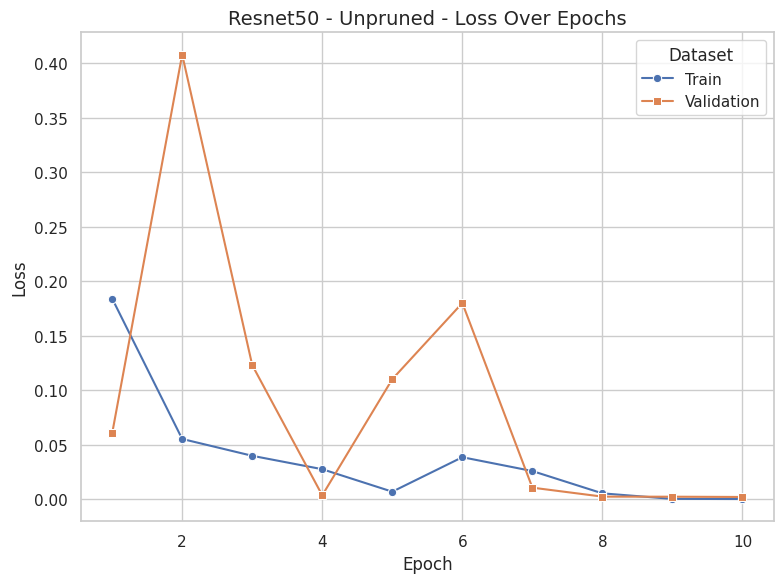

Plot saved as plots/resnet50_Unpruned_accuracy.png


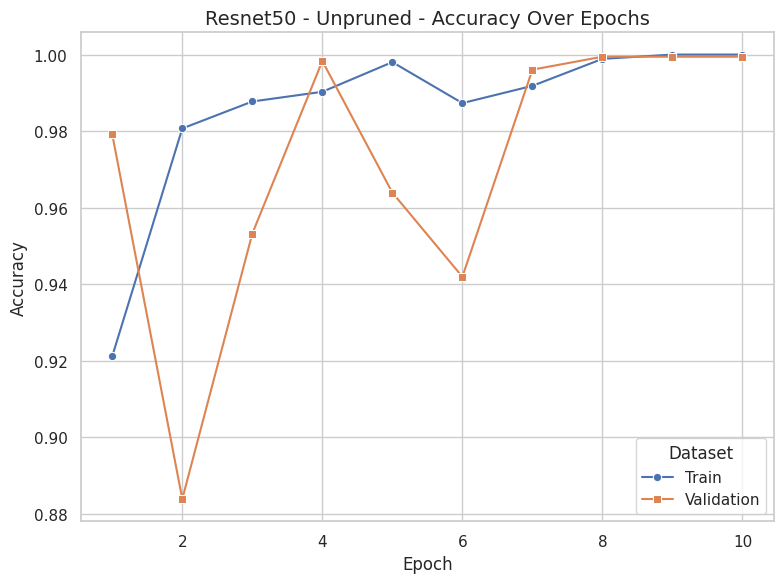

Plot saved as plots/resnet50_Unpruned_f1-score.png


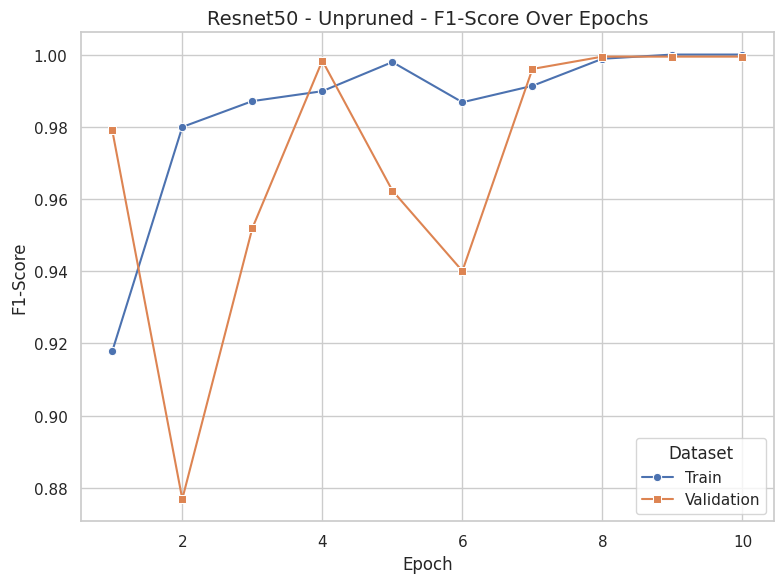


Generating plots for Model: resnet50, Pruning Method: 50% Unstructured Pruning
Plot saved as plots/resnet50_50% Unstructured Pruning_loss.png


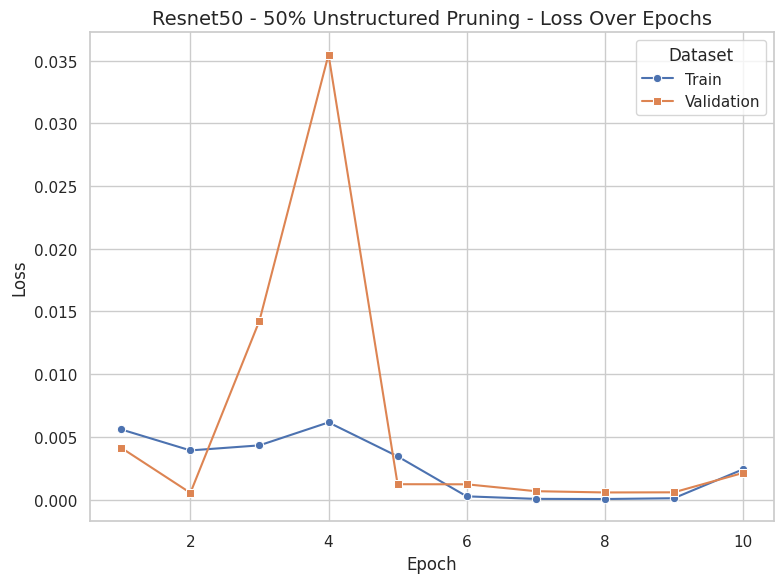

Plot saved as plots/resnet50_50% Unstructured Pruning_accuracy.png


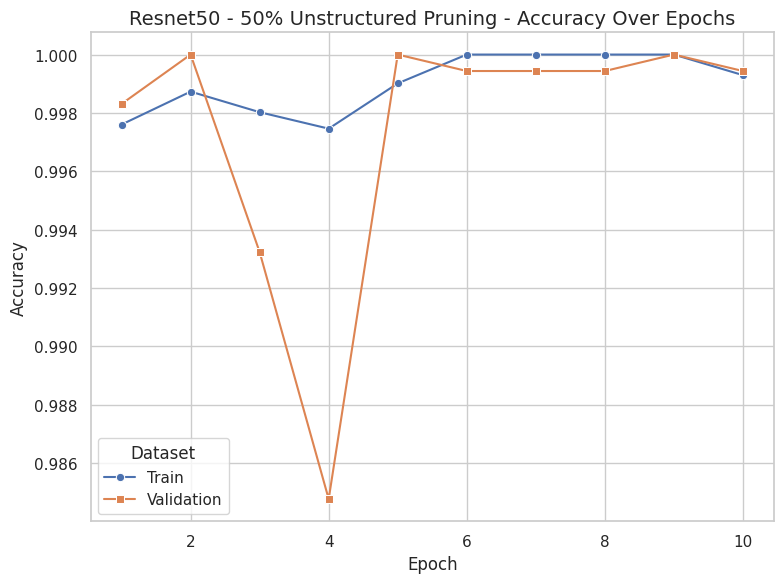

Plot saved as plots/resnet50_50% Unstructured Pruning_f1-score.png


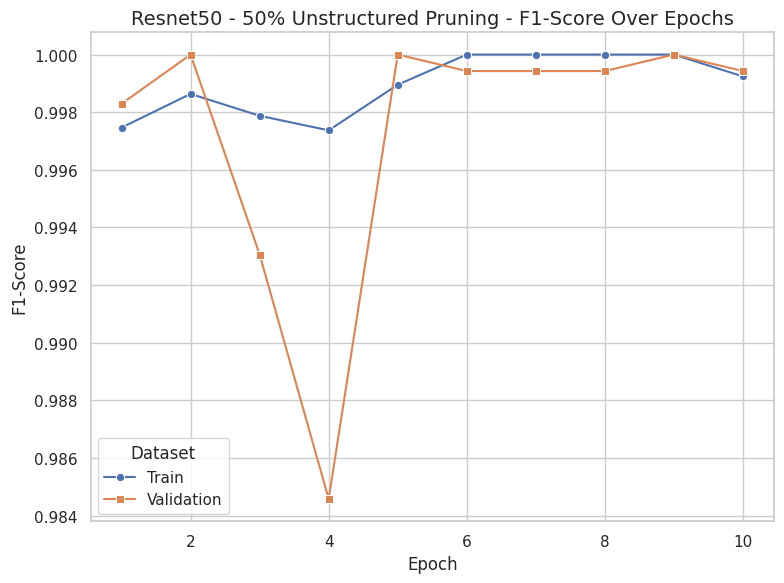


Generating plots for Model: resnet50, Pruning Method: 90% Unstructured Pruning
Plot saved as plots/resnet50_90% Unstructured Pruning_loss.png


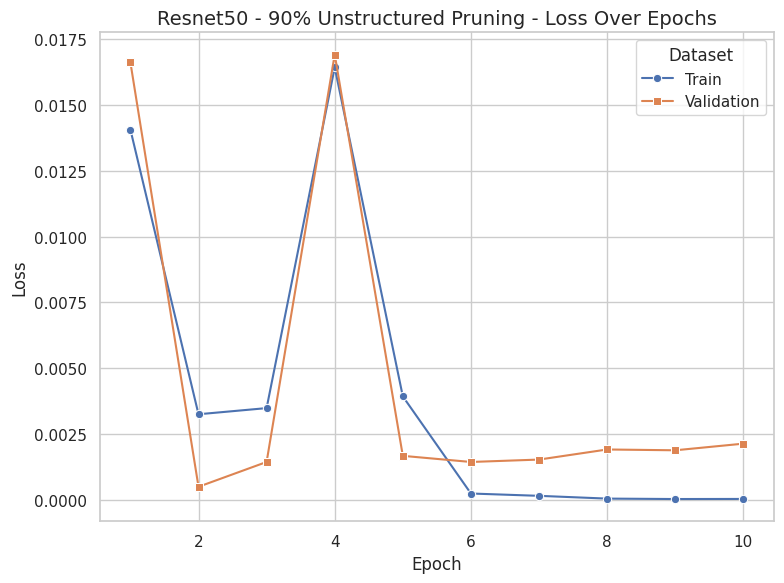

Plot saved as plots/resnet50_90% Unstructured Pruning_accuracy.png


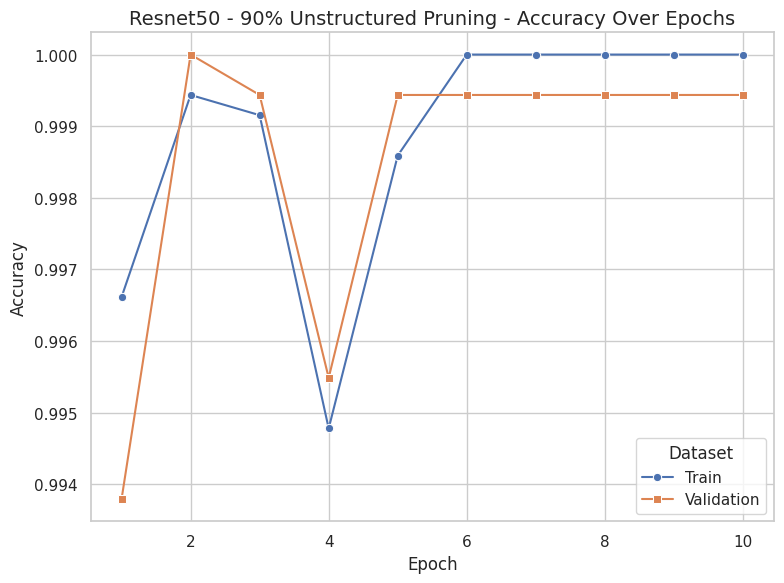

Plot saved as plots/resnet50_90% Unstructured Pruning_f1-score.png


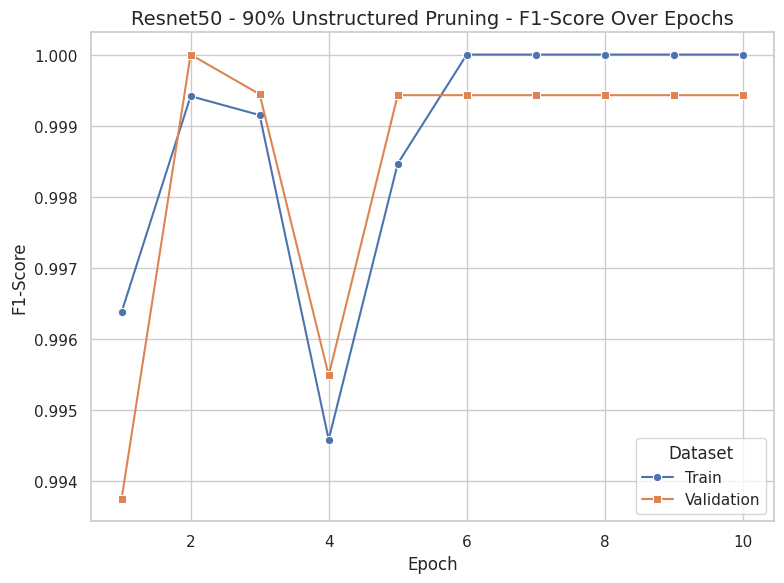


Generating plots for Model: resnet50, Pruning Method: 50% Structured Pruning
Plot saved as plots/resnet50_50% Structured Pruning_loss.png


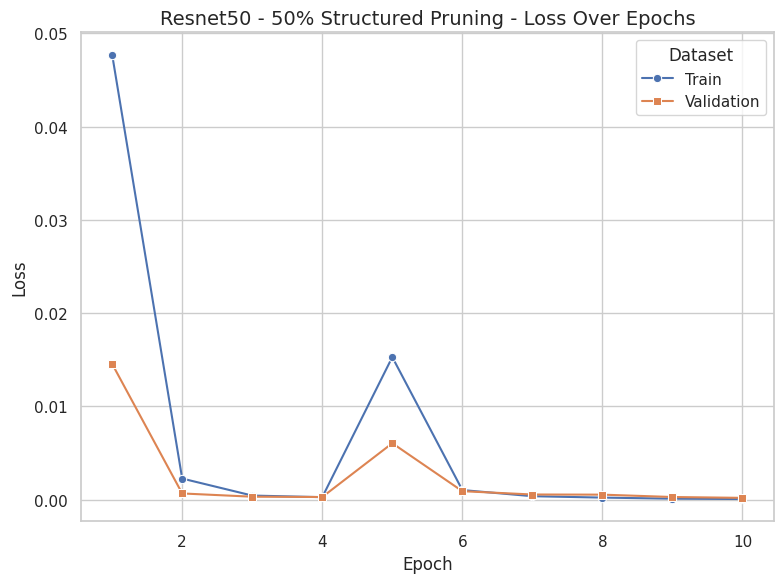

Plot saved as plots/resnet50_50% Structured Pruning_accuracy.png


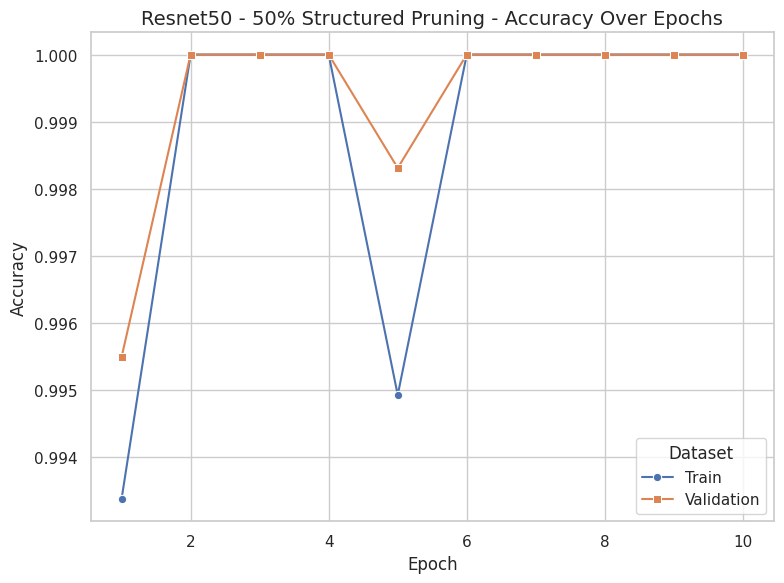

Plot saved as plots/resnet50_50% Structured Pruning_f1-score.png


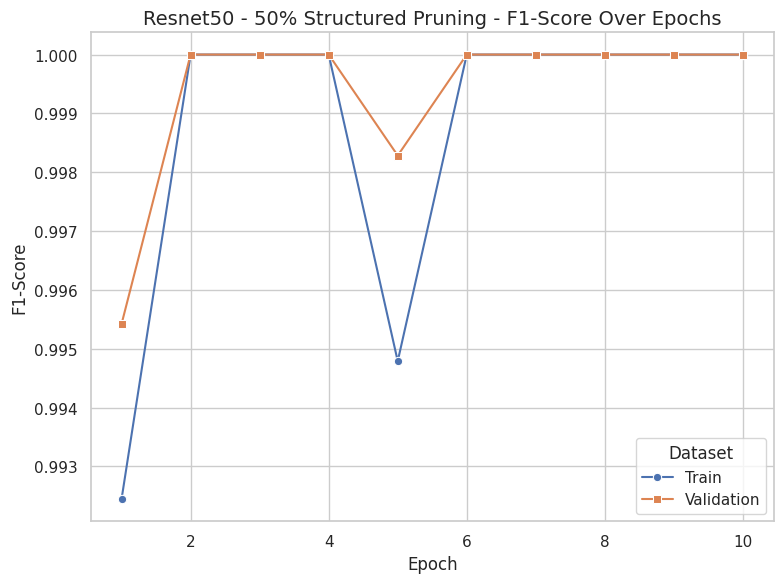


Generating plots for Model: resnet50, Pruning Method: 90% Structured Pruning
Plot saved as plots/resnet50_90% Structured Pruning_loss.png


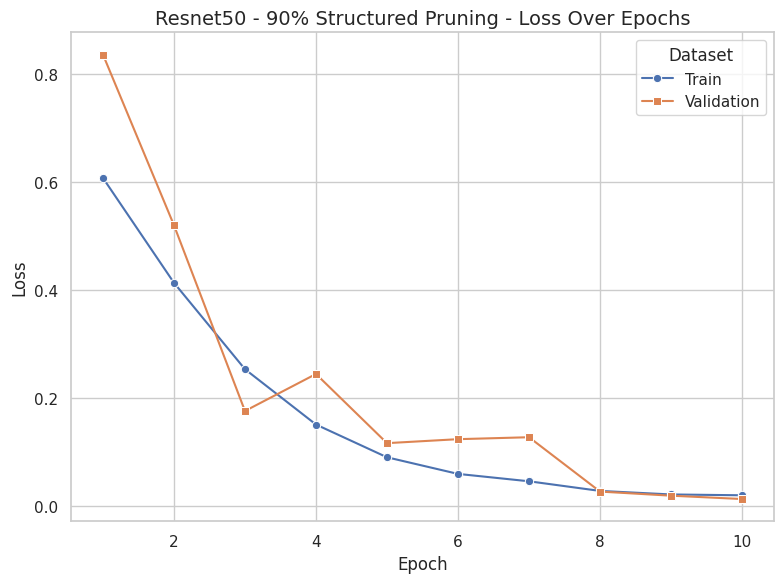

Plot saved as plots/resnet50_90% Structured Pruning_accuracy.png


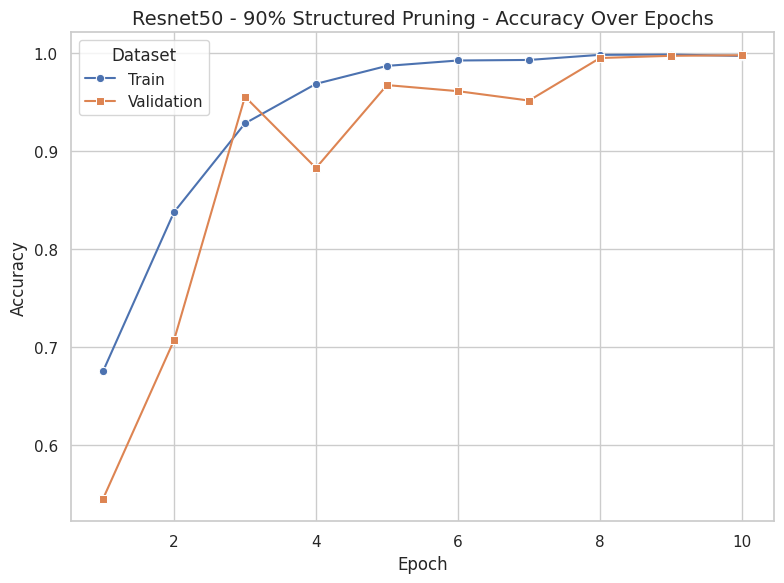

Plot saved as plots/resnet50_90% Structured Pruning_f1-score.png


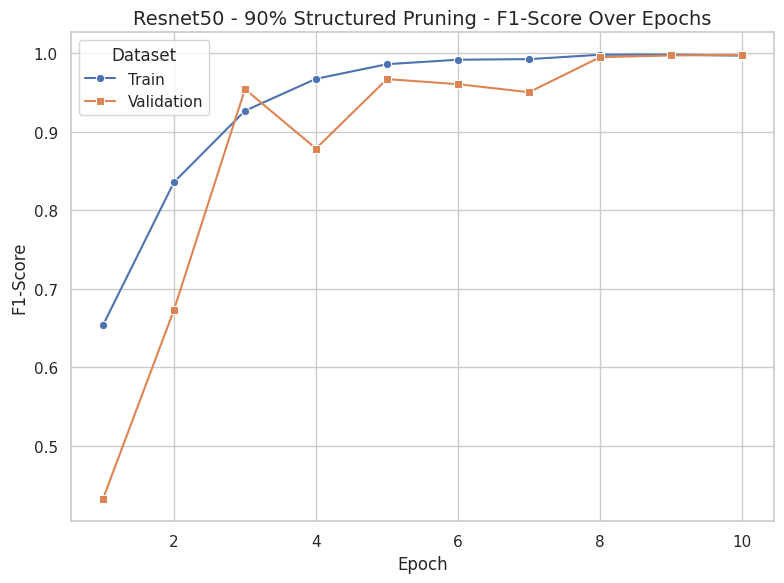


Generating combined Validation Accuracy plot by pruning method...
Plot saved as plots/validation_accuracy_by_pruning.png


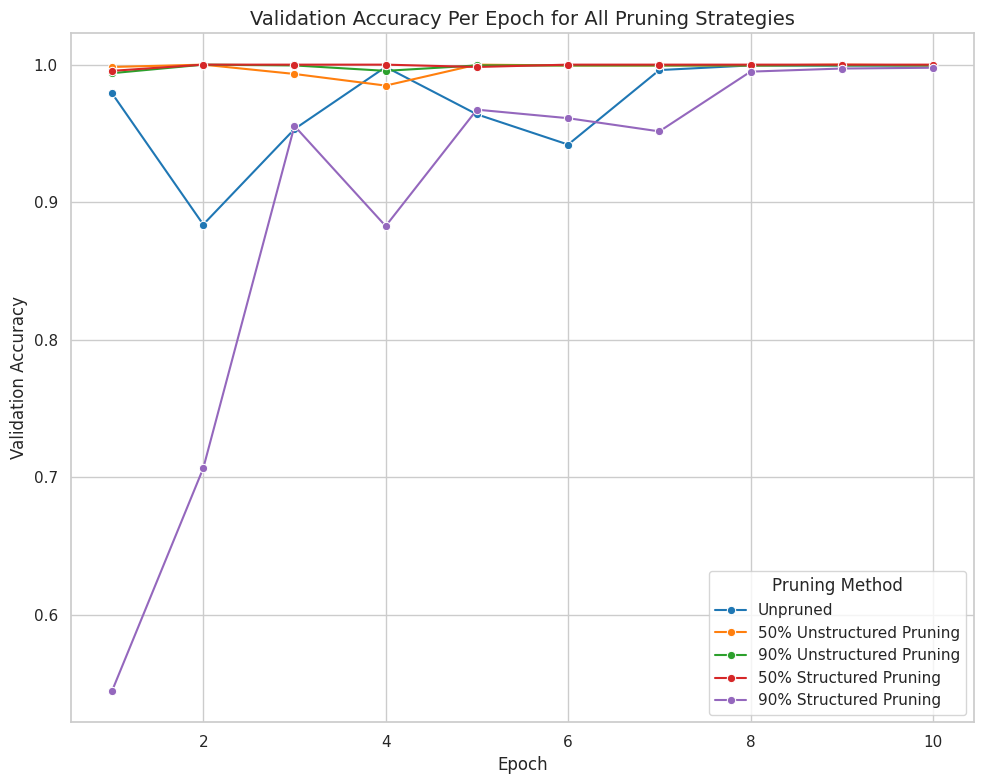


Generating combined Validation Loss plot by pruning method...
Plot saved as plots/validation_loss_by_pruning.png


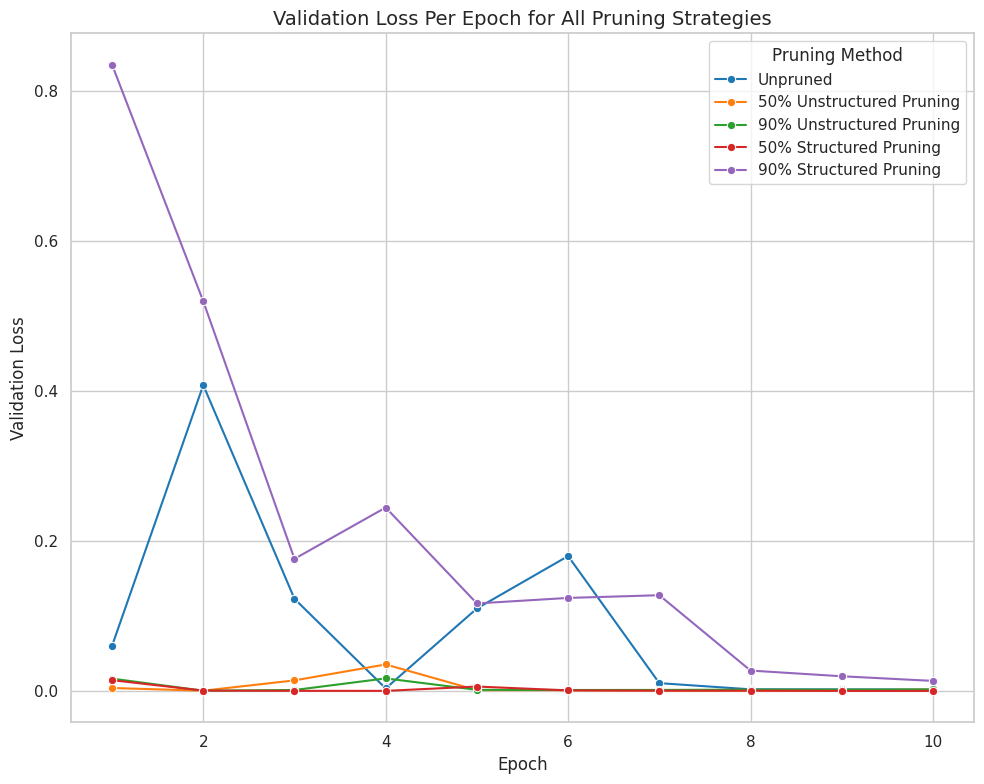


Generating combined Validation Loss plot by pruning method...
Plot saved as plots/validation_F1_by_pruning.png


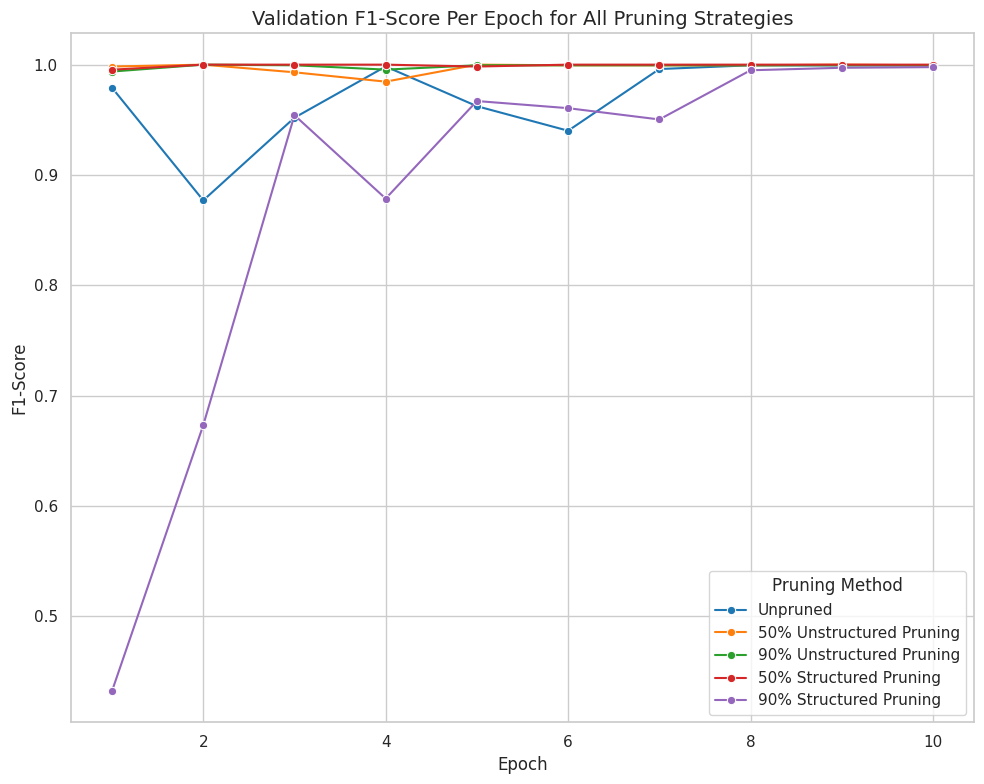

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_metrics(df, model, pruning_method, save_plots=False, save_dir='plots'):
    df_filtered = df[(df['Model'] == model) & (df['Pruning Method'] == pruning_method)]

    if df_filtered.empty:
        print(f"No data found for Model: {model}, Pruning Method: {pruning_method}")
        return

    df_filtered = df_filtered.sort_values(by='Epoch')

    metrics = {
        'Loss': ['Train Loss', 'Validation Loss'],
        'Accuracy': ['Train Accuracy', 'Validation Accuracy'],
        'F1-Score': ['Train F1-Score', 'Validation F1-Score']
    }

    if save_plots:
        os.makedirs(save_dir, exist_ok=True)

    for metric_category, metric_names in metrics.items():
        plt.figure(figsize=(8, 6))
        sns.lineplot(data=df_filtered, x='Epoch', y=metric_names[0], label='Train', marker='o')
        sns.lineplot(data=df_filtered, x='Epoch', y=metric_names[1], label='Validation', marker='s')
        plt.title(f"{model.capitalize()} - {pruning_method} - {metric_category} Over Epochs", fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric_category, fontsize=12)
        plt.legend(title='Dataset')
        plt.tight_layout()

        if save_plots:
            filename = f"{model}_{pruning_method}_{metric_category.lower()}.png"
            filepath = os.path.join(save_dir, filename)
            plt.savefig(filepath)
            print(f"Plot saved as {filepath}")

        plt.show()

# === Additional Figures ===
def plot_combined_metrics_by_pruning(df, metric, title, ylabel, save_plot=False, save_dir='plots', filename=None):
    plt.figure(figsize=(10, 8))
    sns.set_palette("tab10")

    for pruning_method in df['Pruning Method'].unique():
        pruning_data = df[df['Pruning Method'] == pruning_method]
        sns.lineplot(data=pruning_data, x='Epoch', y=metric, label=pruning_method, marker='o')

    plt.title(title, fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(title='Pruning Method')
    plt.tight_layout()

    if save_plot:
        os.makedirs(save_dir, exist_ok=True)
        if not filename:
            filename = f"{metric.replace(' ', '_').lower()}_per_epoch_by_pruning.png"
        filepath = os.path.join(save_dir, filename)
        plt.savefig(filepath)
        print(f"Plot saved as {filepath}")

    plt.show()

# === Main Code ===
csv_file = '/home/mihir_dixit/NNproject/metrics/combined_training_history.csv'

if not os.path.isfile(csv_file):
    raise FileNotFoundError(f"The file '{csv_file}' does not exist in the current directory.")

df = pd.read_csv(csv_file)

print("First few rows of the dataset:")
print(df.head())

sns.set(style="whitegrid")

models = df['Model'].unique()
print(f"Models found: {models}")

pruning_methods = df['Pruning Method'].unique()
print(f"Pruning Methods found: {pruning_methods}")

save_plots = True  # Set to False if you do not want to save plots
save_directory = 'plots'

# Generate individual plots for each model and pruning method
for model in models:
    for pruning in pruning_methods:
        print(f"\nGenerating plots for Model: {model}, Pruning Method: {pruning}")
        plot_metrics(
            df=df,
            model=model,
            pruning_method=pruning,
            save_plots=save_plots,
            save_dir=save_directory
        )

# Generate combined validation accuracy plot by pruning method
print("\nGenerating combined Validation Accuracy plot by pruning method...")
plot_combined_metrics_by_pruning(
    df=df,
    metric='Validation Accuracy',
    title='Validation Accuracy Per Epoch for All Pruning Strategies',
    ylabel='Validation Accuracy',
    save_plot=save_plots,
    save_dir=save_directory,
    filename='validation_accuracy_by_pruning.png'
)

# Generate combined validation loss plot by pruning method
print("\nGenerating combined Validation Loss plot by pruning method...")
plot_combined_metrics_by_pruning(
    df=df,
    metric='Validation Loss',
    title='Validation Loss Per Epoch for All Pruning Strategies',
    ylabel='Validation Loss',
    save_plot=save_plots,
    save_dir=save_directory,
    filename='validation_loss_by_pruning.png'
)

# Generate combined validation F1 plot by pruning method
print("\nGenerating combined Validation Loss plot by pruning method...")
plot_combined_metrics_by_pruning(
    df=df,
    metric='Validation F1-Score',
    title='Validation F1-Score Per Epoch for All Pruning Strategies',
    ylabel='F1-Score',
    save_plot=save_plots,
    save_dir=save_directory,
    filename='validation_F1_by_pruning.png'
)